In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils
import torch.utils.data 
import torch.utils.data.dataloader
import torchvision.models.resnet

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from itertools import groupby

In [3]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.4.0


In [4]:
print(f"Is MPS built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS built? True
Is MPS available? True
Using device: mps


In [5]:
def validate(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            # Send data to device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return correct / total

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# 2. Laden des model Modells ohne vortrainierte Gewichte
#model = models.alexnet(pretrained=True)
model = models.resnet50(pretrained=True)
#model = models.vgg16(pretrained=True)
model = model.to(device)

# 3. & 4. Datensatz vorbereiten und in Trainings- und Validierungssets aufteilen
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 5. Laden des Datensatzes

# Absoluter Pfad basierend auf dem aktuellen Arbeitsverzeichnis
#parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Relative path to the folder containing the images
relative_folderpath = '/Volumes/Crucial X9/Data_MT/Various Smule Vocal Performances/DB/Batch 3/vocal_org/graph/spec'

# Erstellen des Datasets
dataset = datasets.ImageFolder(relative_folderpath, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

random_seed = 2024
torch.manual_seed(random_seed)

# Define the sizes of the train and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print('Train Dataset: ' + str(len(train_dataset)))
print('Validation Dataset: ' + str(len(val_dataset)))
print('Test Dataset: ' + str(len(test_dataset)))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

# 6. Verlustfunktion und Optimierer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#num_epochs = 10

num_epochs = 100  # Setzen Sie eine hohe Anzahl von Epochen
patience = 10  # Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird
best_val_loss = float('inf')
epochs_no_improve = 0

acc = []
loss_values = []

# 7. Trainingsschleife (vereinfacht)
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f'Epoch: {epoch + 1} | Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print('Early stopping!')
        break

# Laden Sie das beste Modell
model.load_state_dict(torch.load('best_model.pth'))
    
    #train_accuracy = validate(model, val_loader)



    #loss_values.append(loss.item())
    #acc.append(train_accuracy)

    #print(f'Epoch: {epoch + 1} | Loss: {loss.item()} | Train Accuracy:  {train_accuracy}')


/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Dataset: 1977
Validation Dataset: 247
Test Dataset: 248
Epoch: 1 | Validation Loss: 0.28020823188126087
Epoch: 2 | Validation Loss: 0.17298963759094477
Epoch: 3 | Validation Loss: 0.41233160346746445
Epoch: 4 | Validation Loss: 0.05828767825732939
Epoch: 5 | Validation Loss: 0.23111302591860294
Epoch: 6 | Validation Loss: 0.16194335371255875
Epoch: 7 | Validation Loss: 0.08027925284113735
Epoch: 8 | Validation Loss: 0.3962883548811078
Epoch: 9 | Validation Loss: 2.294756531715393
Epoch: 10 | Validation Loss: 0.04956370373838581
Epoch: 11 | Validation Loss: 0.052865850913804024
Epoch: 12 | Validation Loss: 0.13383746123872697
Epoch: 13 | Validation Loss: 0.04643250579829328
Epoch: 14 | Validation Loss: 0.07072625248110853
Epoch: 15 | Validation Loss: 0.08967559483426157
Epoch: 16 | Validation Loss: 0.13237669877707958
Epoch: 17 | Validation Loss: 0.18671014870051295
Epoch: 18 | Validation Loss: 0.4410478351637721
Epoch: 19 | Validation Loss: 1.4303198456764221
Epoch: 20 | Validati

/var/folders/4_/cp0xvtt57bs8hr0q5bv1vnw80000gn/T/ipykernel_82019/3724035284.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

<All keys matched successfully>

In [1]:
plt.plot(loss_values)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.show()

NameError: name 'plt' is not defined

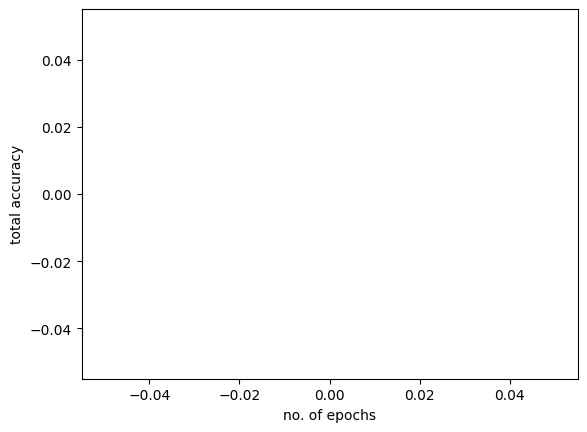

In [14]:
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

In [15]:
model.eval()

with torch.no_grad():
   correct = 0
   total = 0
   true_labels = []
   predicted_labels = []

   for X_test_tensor, Y_test_tensor in test_loader:
      X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)
      outputs = model(X_test_tensor)
      _, predicted = torch.max(outputs.data, 1)

      y_test = Y_test_tensor.cpu().numpy()
      predicted = predicted.cpu().numpy()

      correct += (predicted == y_test).sum().item()
      total += len(y_test)


      true_labels.extend(y_test)
      predicted_labels.extend(predicted)

   unique, counts = np.unique(predicted_labels, return_counts=True)
   predicted_labels_dict = {int(k): int(v) for k, v in zip(unique, counts)}
   print(f'Predicted labels: {predicted_labels_dict}')

   unique, counts = np.unique(true_labels, return_counts=True)
   true_labels_dict = {int(k): int(v) for k, v in zip(unique, counts)}
   print(f'True labels: {true_labels_dict}')

   accuracy = correct / total

   print(f'Accuracy: {accuracy}')

   f1 = f1_score(true_labels, predicted_labels, average='weighted')
   print(f'F1 Score: {f1}')

   precision = precision_score(true_labels, predicted_labels, average='weighted')
   print(f'Precision: {precision}')

   recall = recall_score(true_labels, predicted_labels, average='weighted')
   print(f'Recall: {recall}')


Predicted labels: {0: 78, 1: 93, 2: 77}
True labels: {0: 81, 1: 93, 2: 74}
Accuracy: 0.9798387096774194
F1 Score: 0.9798487865437557
Precision: 0.9803120266829943
Recall: 0.9798387096774194


In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create a DataFrame from the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=['Actual Corrected', 'Actual Original', 'Actual Smoothed'], columns=['Predicted Corrected', 'Predicted Original', 'Predicted Smoothed'])

# Display the DataFrame
print(cm_df)


                  Predicted Corrected  Predicted Original  Predicted Smoothed
Actual Corrected                   77                   0                   4
Actual Original                     0                  93                   0
Actual Smoothed                     1                   0                  73


In [11]:
if not os.path.exists('model/'): os.makedirs('model/')
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model
}, 'model/resNet_complete.pth')

In [12]:
'''
 if average_validation_loss < best_validation_loss:
            best_validation_loss = average_validation_loss
            best_model_state_dict = model.state_dict()
            print(epoch, ' saved!')
'''

"\n if average_validation_loss < best_validation_loss:\n            best_validation_loss = average_validation_loss\n            best_model_state_dict = model.state_dict()\n            print(epoch, ' saved!')\n"